In [13]:
!wget https://storage.googleapis.com/download.magenta.tensorflow.org/datasets/nsynth/nsynth-train.jsonwav.tar.gz
!tar -xvf nsynth-train.jsonwav.tar.gz

--2023-11-23 02:09:07--  https://storage.googleapis.com/download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.205.207, 64.233.164.207, 173.194.73.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.205.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  34.8MB/s    in 12s     

2023-11-23 02:09:20 (26.8 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]

nsynth-test/
nsynth-test/audio/
nsynth-test/audio/guitar_acoustic_010-097-025.wav
nsynth-test/audio/reed_acoustic_023-050-025.wav
nsynth-test/audio/guitar_acoustic_010-049-100.wav
nsynth-test/audio/bass_synthetic_034-039-050.wav
nsynth-test/audio/brass_acoustic_015-052-075.wav
nsynth-test/audio/bass_synthetic_134-065-127.wav
nsynth-test/audio/keyboard_e

In [1]:
import torch
import json
import os
import numpy as np
from torch.utils.data import Dataset
from torch import Tensor
from torchaudio import load
import librosa
from torchvision import transforms
from matplotlib import pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [16]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [23]:
data_path='./nsynth-test/nsynth-train/audio'
json_path='nsynth-test/nsynth-train/examples.json'
batch_size=32

In [3]:
f = open(json_path, "r")
targets = json.load(f)

In [4]:
targets['guitar_acoustic_001-082-050']['pitch']

82

In [5]:
def get_mel_spectrogram(waveform, sample_rate):
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform.numpy(), sr=sample_rate)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_spectrogram = torch.from_numpy(mel_spectrogram).unsqueeze(0) 
    return mel_spectrogram.clone().detach()

In [6]:
class NSynthDataset(Dataset):
    def __init__(self):
        self.data_path = data_path
        self.file_list = os.listdir(self.data_path)
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file = self.file_list[idx]
        file_name = file.split('.')[0]
        pitch = targets[file_name]['pitch']
        waveform, sample_rate = load(os.path.join(self.data_path, file))
        mel_spec = get_mel_spectrogram(waveform, sample_rate)[0][0]
        return mel_spec, pitch

In [7]:
nsynth_dataset = NSynthDataset()

31

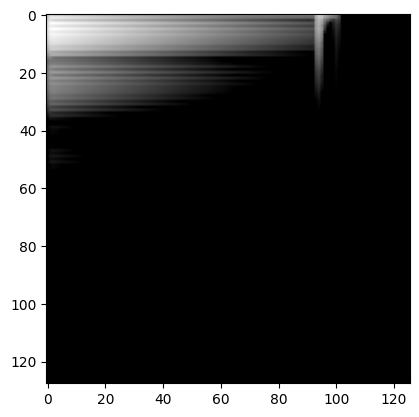

In [8]:
spec, name = nsynth_dataset[5]
plt.imshow(spec, cmap="gray")
name

In [24]:
train_loader = torch.utils.data.DataLoader(
    nsynth_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    nsynth_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

In [25]:
x_batch, y_batch = next(iter(train_loader))
x_batch.reshape(x_batch.shape[0], -1).shape, y_batch.shape

(torch.Size([32, 16128]), torch.Size([32]))

In [26]:
features = 16128
hidden = 4096
classes = 128

In [27]:
w1 = (torch.FloatTensor(features, hidden).uniform_(-1, 1) / features**0.5).to(device)
w2 = (torch.FloatTensor(hidden, hidden).uniform_(-1, 1) / features**0.5).to(device)
w3 = (torch.FloatTensor(hidden, classes).uniform_(-1, 1) / features**0.5).to(device)
w1.requires_grad_(True)
w2.requires_grad_(True)
w3.requires_grad_(True)

tensor([[-0.0008,  0.0054,  0.0077,  ..., -0.0043,  0.0009,  0.0029],
        [-0.0062, -0.0057,  0.0071,  ..., -0.0005, -0.0031,  0.0033],
        [-0.0034,  0.0031, -0.0034,  ...,  0.0055, -0.0048,  0.0069],
        ...,
        [-0.0002,  0.0073, -0.0032,  ...,  0.0030, -0.0041, -0.0065],
        [-0.0064, -0.0066,  0.0038,  ...,  0.0024, -0.0071,  0.0066],
        [ 0.0011, -0.0012,  0.0077,  ...,  0.0056,  0.0053, -0.0014]],
       device='cuda:0', requires_grad=True)

In [28]:
epochs = 100
lr=0.001
history=[]

In [29]:
from torch.nn.functional import cross_entropy

In [30]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.reshape(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)
    hidden1 = x_batch @ w1
    hidden2 = hidden1 @ w2
    logits = hidden2 @ w3
    probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)
    loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
    history.append(loss.item())
    loss.backward()
    grad1 = w1.grad
    grad2 = w2.grad
    grad3 = w3.grad
    with torch.no_grad():
      w1 -= lr * grad1
      w2 -= lr * grad2
      w3 -= lr * grad3
    w1.grad.zero_()
    w2.grad.zero_()
    w3.grad.zero_()
  print(f'{i+1}: loss {history[-1]}')

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
